# Car accident

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chardet
import datetime
import os
from tueplots import bundles
from tueplots.constants.color import rgb
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

if not os.path.exists('Graphen'):
    os.mkdir('Graphen')
if not os.path.exists('Daten'):
    os.mkdir('Daten')

In [2]:
try:
    accidents = pd.read_csv('FARS2021NationalCSV/accident.csv',encoding='WINDOWS-1252')
except:
    with open('FARS2021NationalCSV/accident.csv', 'rb') as f:
        result = chardet.detect(f.read())  # or readline if the file is large
    accidents = pd.read_csv('FARS2021NationalCSV/accident.csv',encoding=result)
    print(result)
accidents['date'] = pd.to_datetime(accidents[['YEAR','MONTH','DAY']])


try:
    people = pd.read_csv('Daten/people.csv',index_col=0)
except:
    people = pd.read_csv('https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv',encoding='ISO-8859-10')
    people.to_csv('Daten/people.csv')
    
try:
    Google_daten = pd.read_csv('Daten/Google_daten(US).csv',parse_dates=['date'],index_col=0)
except:
    Google_daten = pd.read_csv('https://storage.googleapis.com/covid19-open-data/v2/main.csv',skiprows=range(1,14096993),nrows=2368485,parse_dates=['date'])
    Google_daten.sort_values(by=['subregion1_name','date'])
    Google_daten.to_csv('Daten/Google_daten(US).csv')

#remove unnecessary data
Google_daten = Google_daten.groupby(by=['subregion1_name','date']).first().reset_index()


print(people[people['CTYNAME'].isin(people['STNAME'])][['STATE','CTYNAME','POPESTIMATE2021']].groupby('STATE').first())
print(accidents.columns)
print(accidents)

/tmp/ipykernel_27309/2525813892.py:18: DtypeWarning: Columns (12,13,103) have mixed types. Specify dtype option on import or set low_memory=False.
  Google_daten = pd.read_csv('Daten/Google_daten(US).csv',parse_dates=['date'],index_col=0)


                    CTYNAME  POPESTIMATE2021
STATE                                       
1                   Alabama          5039877
2                    Alaska           732673
4                   Arizona          7276316
5                  Arkansas          3025891
6                California         39237836
8                  Colorado          5812069
9               Connecticut          3605597
10                 Delaware          1003384
11     District of Columbia           670050
12                  Florida         21781128
13                  Georgia         10799566
15                   Hawaii          1441553
16                    Idaho          1900923
17                 Illinois         12671469
18                  Indiana          6805985
19                     Iowa          3193079
20                   Kansas          2934582
21                 Kentucky          4509394
22                Louisiana          4624047
23                    Maine          1372247
24        

In [3]:
print(Google_daten)
Google_daten = Google_daten.groupby(by=['subregion1_name','date']).first().reset_index()
Google_daten = Google_daten.sort_values(by=['subregion1_name','date'])
temp = accidents
#print(temp['subregion1_name'].unique())
print(Google_daten['subregion1_name'].unique())
temp['subregion1_name'] = temp['STATENAME']
temp = temp.groupby(['subregion1_name','date']).size().reset_index(name='cases')
Google_daten = pd.merge(Google_daten,temp, on=['subregion1_name','date'],how='left')
Google_daten = Google_daten.fillna(0)
print(Google_daten[['subregion1_name','date','cases']])


accidents_state = accidents.value_counts('STATE',sort=False).to_frame()
accidents_state['CASES'] = accidents_state['count']
del accidents_state['count']



accidents_state['STATENAME'] = accidents['STATENAME'].unique()
accidents_state['Population'] = Google_daten[Google_daten['date']>'2021'].groupby('subregion1_name').first()['population'][accidents['STATENAME'].unique()].to_numpy()

accidents_state['POPULATION_2021'] = people[people['CTYNAME'].isin(people['STNAME'])].groupby('STATE').first()['POPESTIMATE2021']
accidents_state['CASES_NORM'] = accidents_state['CASES']/accidents_state['Population']
accidents_state['CASES/100000'] = accidents_state['CASES_NORM']*100000

Google_daten['CASES/100000'] = Google_daten['cases']/Google_daten['population']*100000

print(accidents_state)

      subregion1_name       date    key                     place_id wikidata  \
0             Alabama 2020-01-01  US_AL  ChIJdf5LHzR_hogR6czIUzU0VV4     Q173   
1             Alabama 2020-01-02  US_AL  ChIJdf5LHzR_hogR6czIUzU0VV4     Q173   
2             Alabama 2020-01-03  US_AL  ChIJdf5LHzR_hogR6czIUzU0VV4     Q173   
3             Alabama 2020-01-04  US_AL  ChIJdf5LHzR_hogR6czIUzU0VV4     Q173   
4             Alabama 2020-01-05  US_AL  ChIJdf5LHzR_hogR6czIUzU0VV4     Q173   
...               ...        ...    ...                          ...      ...   
40371         Wyoming 2021-12-17  US_WY  ChIJaS7hSDTiXocRLzh90nkisCY    Q1214   
40372         Wyoming 2021-12-18  US_WY  ChIJaS7hSDTiXocRLzh90nkisCY    Q1214   
40373         Wyoming 2021-12-19  US_WY  ChIJaS7hSDTiXocRLzh90nkisCY    Q1214   
40374         Wyoming 2021-12-20  US_WY  ChIJaS7hSDTiXocRLzh90nkisCY    Q1214   
40375         Wyoming 2021-12-21  US_WY  ChIJaS7hSDTiXocRLzh90nkisCY    Q1214   

      datacommons country_c

## List cases

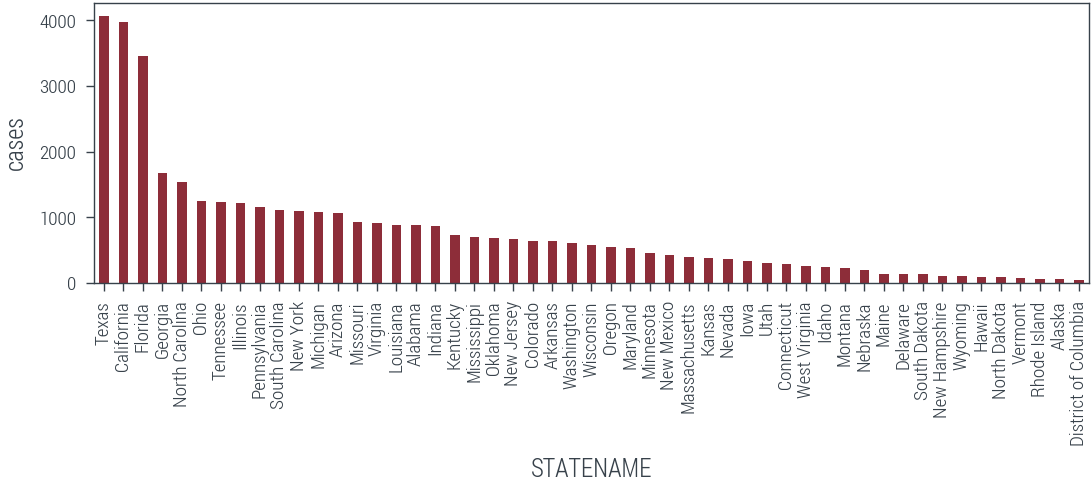

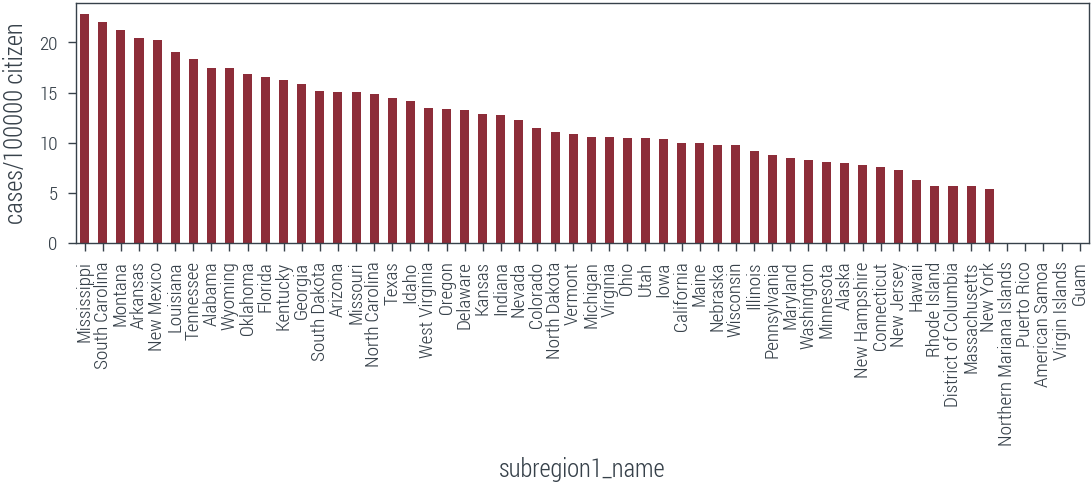

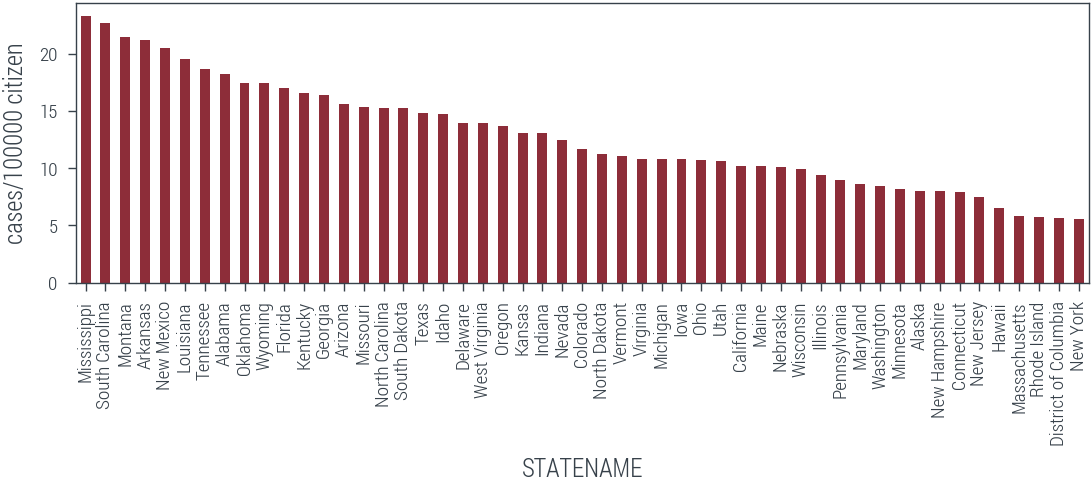

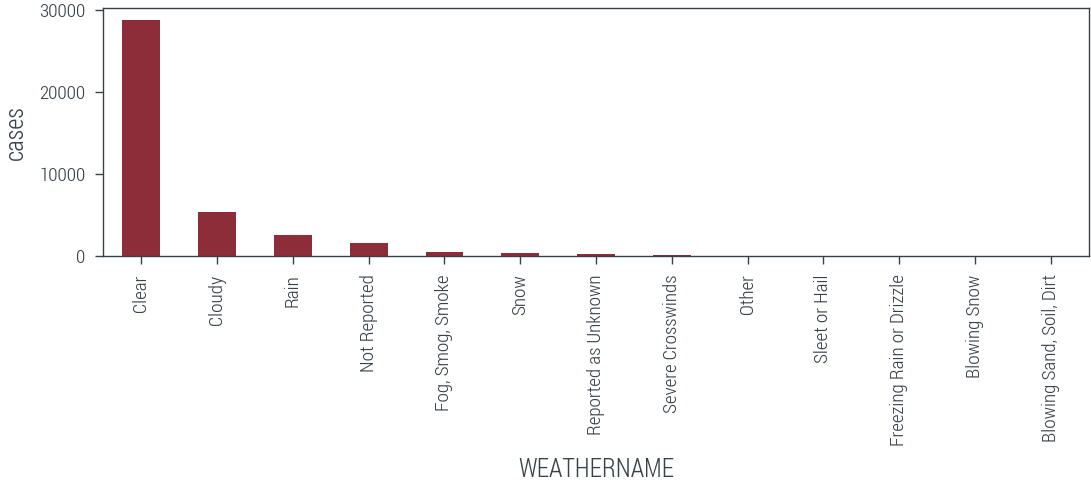

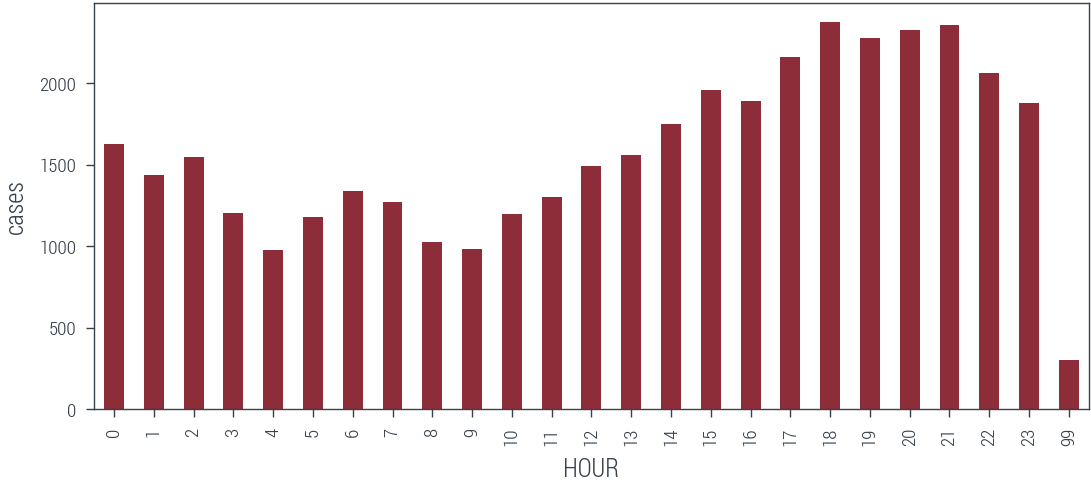

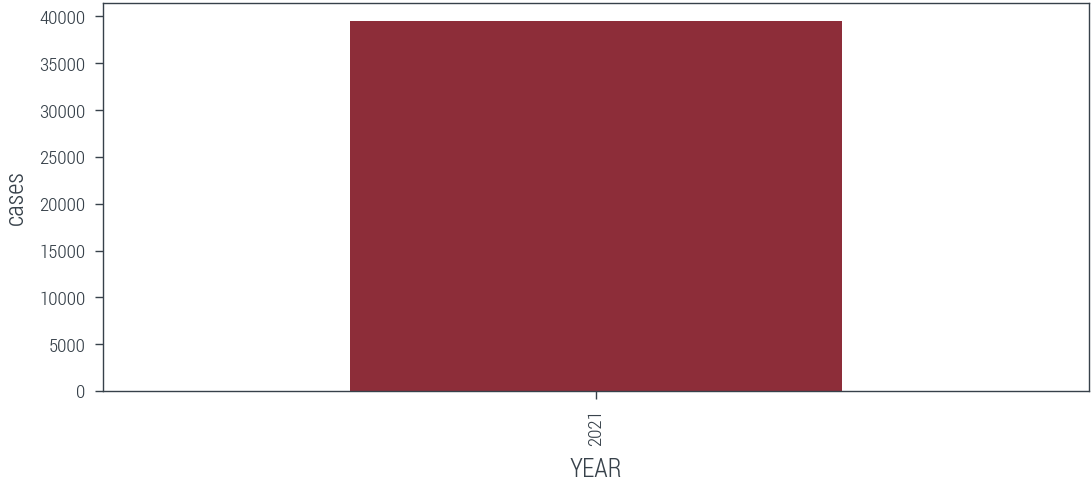

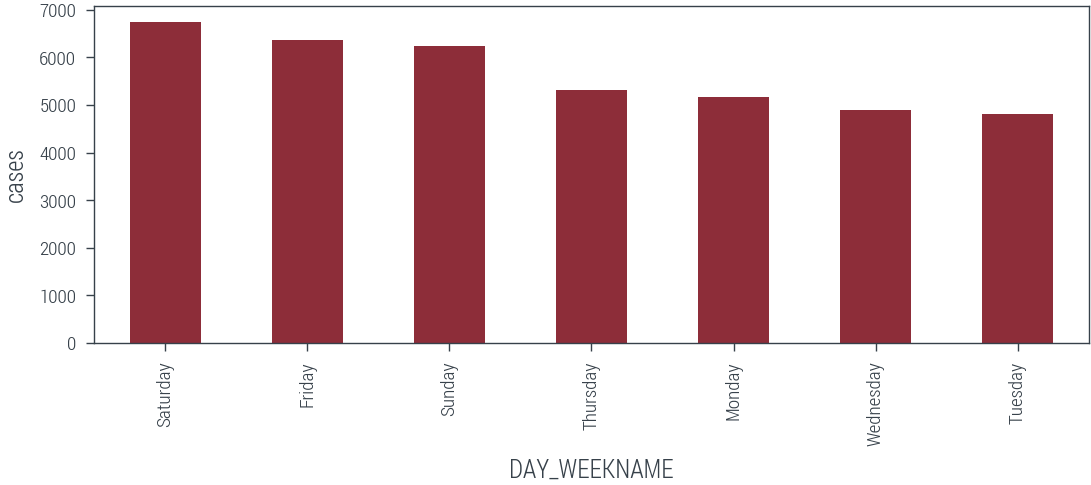

<Figure size 1102.36x496.063 with 0 Axes>

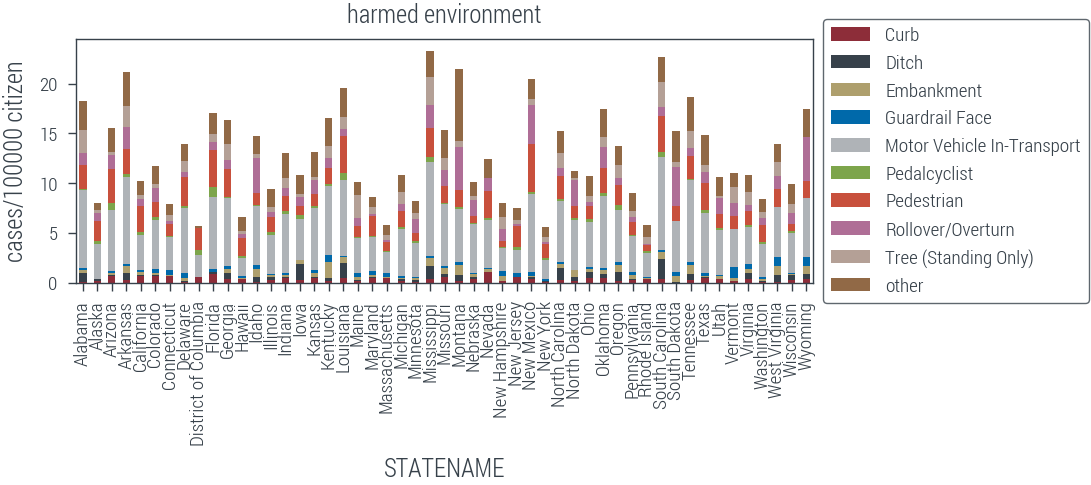

In [12]:


plt.figure()
accidents['STATENAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()

Google_daten.groupby('subregion1_name')['CASES/100000'].sum().sort_values(ascending=False).plot(kind='bar')
#Google_daten.groupby('subregion1_name')['mobility_workspaces'].first().plot(kind='bar')
plt.ylabel('cases/100000 citizen')
plt.show()


plt.figure()
#plt.title('cases per 100000 habitants')
accidents_state.set_index('STATENAME')['CASES/100000'].sort_values(ascending=False).plot.bar()
plt.ylabel('cases/100000 citizen')
plt.show()

plt.figure()
accidents['WEATHERNAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['HOUR'].value_counts().sort_index().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['YEAR'].value_counts().sort_index().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['DAY_WEEKNAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()


accidents['HARM_EVNAME'] = accidents['HARM_EVNAME'].replace(accidents['HARM_EVNAME'].value_counts().index[10:],'other')

plt.figure()
accidents.groupby(['STATENAME','HARM_EVNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['Population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
plt.title('harmed environment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()